# Reading the data

In [1]:
# basic imports
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

dataPath = "../data/"

In [2]:
# reading CSV file
reader = csv.reader(open(dataPath + 'features_2.csv', 'r'), delimiter=',')
data_full = np.array(list(reader))
reader = csv.reader(open(dataPath + 'all_endpoints_with_missing_values_012615.csv', 'r'), delimiter=',')
activity_full = np.array(list(reader))

In [3]:
# feature names
feature_names = data_full[0, 1:]

# names of the proteins
protein_names = data_full[1:, 0]
protein_names1 = activity_full[1:, 0]
print 'Protein names equality check:', np.array_equal(protein_names1, protein_names)

# names of receptors
receptor_names = activity_full[0, 1:]

# Object-Feature matrix (proteins description)
X = data_full[1:, 1:].astype('double')

# Activity matrix
Y = activity_full[1:, 1:].astype('int16')

# Removing constant features
ind = np.var(X, axis = 0) != 0
X = X[:, ind]
feature_names = feature_names[ind]

# Number of features
N = X.shape[1]

Protein names equality check: True


In [4]:
print receptor_names

['NR-AhR' 'NR-AR-LBD' 'NR-AR' 'SR-MMP' 'NR-ER' 'SR-HSE' 'SR-p53'
 'NR-PPAR-gamma' 'SR-ARE' 'NR-Aromatase' 'SR-ATAD5' 'NR-ER-LBD']


# Training classifiers and printing results

In [5]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold as SKF
import sklearn

In [6]:
def getB(n):
    if n == 0:
        return(None)
    if n == 1:
        return([[0], [1]])
    else:
        res0 = getB(n - 1)
        res = list()
        for a in res0:
            res.append([0] + a)
        for a in res0:
            res.append([1] + a)
        return(res)
def plotROCCurve(fpr, tpr, text, filename):
    """
     Plot a ROC curve from fpr, tpr
    """

    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    params = {'text.usetex' : True,
       'font.size' : 15,
#          'font.family' : 'lmodern',
       'text.latex.unicode': True}
    plt.rcParams.update(params) 
    plt.plot(fpr, tpr, label = None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR', fontsize=15)
    plt.ylabel('TPR', fontsize=15)
    plt.tick_params(axis='both', which='major')
    plt.title(str(text), fontsize=15)
    if filename != None:
        plt.savefig(filename + ".eps", bbox_inches = 'tight')
    plt.show()
def getShowROC(classifier, Xc, Yc):
        Ys = classifier.decision_function(Xc)
        fpr, tpr, _ = roc_curve(Yc, Ys)
        plotROCCurve(fpr, tpr, "ROC", None)

In [72]:
class PCC:
    Xc = None
    Yc = None
    C = None
    X = None
    Y = None
    badValue = None
    m = 0
    def __init__(self):
        return None
    def initialize(self, m, X, Y, badValue):
        self.X = np.copy(X)
        self.Y = np.copy(Y)
        self.Xc = [None] * m
        self.Yc = [None] * m
        self.badValue = badValue
        self.m = m
        self.C = [None] * m
    #def fit(self, X, Y, badValue = 999):
    #    for i in range(Y.shape[1]):
    #        fitOne(self, X, Y, badValue, i)
    def fitOne(self, i):
        self.C[i] = None
        ind = np.where(self.Y[:, i] != self.badValue)
        X0 = self.X[ind]
        Yc = self.Y[ind][:, i]
        Y1 = np.copy(self.Y[ind][:, 0:i])
        
        #print Yc.shape
        #print Y1.shape
        
        #for k in range(Y1.shape[0]):
        #    for j in range(Y1.shape[1]):
        #        if Y1[k, j] == self.badValue:
        #            #print k, j
        #            Y1[k, j] = self.predict(X0[k], j)
        
        if Y1.shape[1] > 0:
            #print X[ind].shape
            #print Y1.shape
            Xc = np.concatenate((self.X[ind], Y1), axis=1)
        else:
            Xc = self.X[ind]
        
        self.Xc[i] = Xc
        self.Yc[i] = Yc
        
        tmpLR = LR(fit_intercept = False, solver='liblinear', n_jobs=3)
        tmpLR.fit(Xc, Yc)
        self.C[i] = tmpLR
    def adjustOne(self, i, fprThresold = 0.2):
        Xc = self.Xc[i]
        Yc = self.Yc[i]
        #getShowROC(self.C[i], Xc, Yc)
        objInd = self.getIndexByFPR(i, fprThresold)
        self.setClassifierObject(i, objInd)
        self.showFPRTPR(i)
    def updatePredictions(self, j):
        for i in range(self.X.shape[0]):
            if self.Y[i][j] == self.badValue:
                self.Y[i][j] = self.predict(X[i], j)
    def showFPRTPR(self, i):
        Xc = self.Xc[i]
        Yc = self.Yc[i]
        classifier = self.C[i]
        N = len(np.where(Yc == 0)[0])
        P = len(np.where(Yc == 1)[0])
        TP = len(np.where((classifier.predict(Xc) == 1) & (Yc == 1))[0])
        FP = len(np.where((classifier.predict(Xc) == 1) & (Yc == 0))[0])
        print("Got FPR=%.1f %% TPR=%.1f %%" % (100. * FP / N, 100. * TP / P))
    def getIndexByFPR(self, i, fprLow):
        classifier = self.C[i]
        Xc = self.Xc[i]
        Yc = self.Yc[i]
        YScore = classifier.decision_function(Xc)
        Ys = np.argsort(YScore)[::-1]
        N = len(np.where(Yc==0)[0])
        P = len(np.where(Yc==1)[0])
        fpr0 = 0
        tpr0 = 0
        res = None
        for i in range(Ys.shape[0]):
            ansr = Yc[Ys[i]]
            if ansr == 0:
                fpr0 += 1
            if ansr == 1:
                tpr0 += 1
                
            if 1. * fpr0 / N >= fprLow and res == None:
                return(Ys[i])
    def setClassifierObject(self, i, index):
        classifier = self.C[i]
        Xc = self.Xc[i]
        classifier.intercept_ = 0
        classifier.intercept_ = -classifier.decision_function([Xc[index]])
    def probabilityNew(self, x, v, i):
        v1 = v
        v1[i] = 0
        p0 = self.probabilityItem(x, v1)
        v1[i] = 1
        p1 = self.probabilityItem(x, v1)
        return(p1 / (p0 + p1))
    def probabilityItem(self, x, y):
        res = 1
        for i in range(len(y)):
            x1 = list(x) + y[0:i]
            if self.C[i] != None:
                res *= self.C[i].predict_proba([x1])[0][y[i]]
        return(res)
    def probabilityClassRecursive(self, x, ic, il = 0):
        if ic == il:
            if self.C[ic] == None:
                return 0
            else:
                return self.C[ic].predict_proba([x])[0][1]
        else:
            fl = self.C[il].predict_proba([x])[0][1]
            return(fl * self.probabilityClassRecursive(list(x) + [1], ic, il + 1) + 
                  (1 - fl) * self.probabilityClassRecursive(list(x) + [0], ic, il + 1))
    def probabilityClasses(self, x):
        res = np.zeros(self.m)
        i = 0
        v = self.probabilityClassesSubset(x)
        while i < self.m:
            if self.C[i] != None:
                res[i] = self.probabilityNew(x, v, i)
            i += 1
        return(res)
#    def probabilityClassesSlow(self, x):
#        m0 = 0
#        while m0 < self.m:
#            if self.C[m0] == None:
#                break
#            m0 += 1
#        Bm0 = getB(m0)
#        res = np.zeros(self.m)
#        for v in Bm0:
#            for j in range(m0):
#                if v[j] == 1:
#                    res[j] += probabilityItem(self, x, v)
#        return(res)
    def probabilityClassesSubset(self, x):
        m0 = 0
        while m0 < self.m:
            if self.C[m0] == None:
                break
            m0 += 1
        Bm0 = getB(m0)
        res = None
        maxP = 0
        for v in Bm0:
            p = self.probabilityItem(x, v)
            if p > maxP:
                res = v
                maxP = p
        res = res + [0] * (self.m - m0)
        return(res)
    def predict(self, x, i):
        #return(self.probabilityClassRecursive(x, i) >= 0.5)
        v = a.probabilityClassesSubset(x)
        return(self.probabilityNew(x, v, i) >= 0.5)

In [118]:
a = PCC()
a.initialize(Y.shape[1], X, Y, 999)
for i in range(5):
    %time a.fitOne(i)
    %time a.adjustOne(i, 0.2)
    %time a.updatePredictions(i)

CPU times: user 4.92 s, sys: 4 ms, total: 4.93 s
Wall time: 4.92 s
Got FPR=20.0 % TPR=86.9 %
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 12.9 ms
CPU times: user 1.8 s, sys: 8 ms, total: 1.81 s
Wall time: 1.81 s
CPU times: user 4.29 s, sys: 0 ns, total: 4.29 s
Wall time: 4.28 s
Got FPR=20.0 % TPR=92.4 %
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.8 ms
CPU times: user 3.55 s, sys: 8 ms, total: 3.56 s
Wall time: 3.55 s
CPU times: user 4.79 s, sys: 4 ms, total: 4.8 s
Wall time: 4.79 s
Got FPR=20.0 % TPR=89.6 %
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.6 ms
CPU times: user 7.12 s, sys: 0 ns, total: 7.12 s
Wall time: 7.11 s
CPU times: user 5.93 s, sys: 0 ns, total: 5.93 s
Wall time: 5.92 s
Got FPR=20.0 % TPR=88.7 %
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11 ms
CPU times: user 21.9 s, sys: 4 ms, total: 21.9 s
Wall time: 21.8 s
CPU times: user 5.95 s, sys: 0 ns, total: 5.95 s
Wall time: 5.94 s
Got FPR=20.0 % TPR=75.5 %
CPU tim

In [134]:
v=a.probabilityClasses(X[46])
print v
print a.probabilityItem(X[46], [1])

[ 0.21072067  0.02450416  0.96091743  0.6705633   0.93124928  0.          0.
  0.          0.          0.          0.          0.        ]
0.370727099766


In [139]:
a.probabilityClassRecursive(X[46],0)
a.probabilityClassRecursive(X[46],0)

0.37072709976614682

In [136]:
a.probabilityClassesSubset(X[46])

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [48]:
def probabilityNew(self, x, v, i):
        v1 = v
        v1[i] = 0
        p0 = self.probabilityItem(x, v1)
        v1[i] = 1
        p1 = self.probabilityItem(x, v1)
        return(p1 / (p0 + p1))

a.probabilityNew(X[46], v, 4)
a.predict(X[46], 2)

TypeError: probabilityNew() takes exactly 4 arguments (3 given)

In [25]:
Y[46]

array([999, 999, 999, 999, 999,   0, 999, 999, 999, 999, 999, 999], dtype=int16)

In [74]:
def getXY(classToTrain, X, Y, badValue = 999):
    """
    Get objects and answers for class classToTrain
    for which answers are available
    """
    
    haveAnswersObjectsIndices = np.where(Y[:, classToTrain] != badValue)
    classX = X[haveAnswersObjectsIndices, :][0]
    classY = Y[haveAnswersObjectsIndices, classToTrain][0]
    return classX, classY

In [148]:
def AUCAll(thresold):
    folds = 5
    IFolds = sklearn.cross_validation.KFold(n = X.shape[0], n_folds=folds, shuffle=True,
                                   random_state=32)
    #IFolds = SKF(Y, folds)
    maxC = 6

    roc_auc = np.zeros((folds, maxC))
    fold = 0
    for (ITrain, ITest) in IFolds:
        # get train & test data
        XTrain, YTrain = X[ITrain], Y[ITrain]
        XTest,  YTest  = X[ITest],  Y[ITest]

        Ys = np.zeros(YTest.shape)

        algo = PCC()
        algo.initialize(YTrain.shape[1], XTrain, YTrain, 999)
        for i in range(maxC):
            print("fit %d" % i)
            algo.fitOne(i)
            print("adjust %d" % i)
            algo.adjustOne(i, thresold)
            print("updatePredictions %d" % i)
            algo.updatePredictions(i)

        print("calculating ROC...")

        for j in range(XTest.shape[0]):
            Ys[j] = algo.probabilityClasses(XTest[j])

        for i in range(maxC):
            ind = np.where(YTest[:, i] != 999)
            X1 = XTest[ind]
            Y1 = YTest[ind, i][0]
            Ys0 = Ys[ind, i][0]

            fpr, tpr, _ = roc_curve(Y1, Ys0)
            plotROCCurve(fpr, tpr, "Fold %d Class %d ROC thr %f" % (fold + 1, i + 1, thresold), None)
            roc_auc[fold][i] = auc(fpr, tpr)
        fold += 1

    res = np.zeros(maxC)

    for i in range(maxC):
        auc_mean = np.mean(roc_auc[:, i])
        auc_std = np.std(roc_auc[:, i])
        res[i] = auc_mean
        print("Class %d AUC %.2g +- %.1g thres %f" % (i + 1, auc_mean, auc_std, thresold))
    return(res)

In [142]:
res=dict()
for th in np.arange(0.1, 0.5, 0.1):
    res[th] = AUCAll(th)

fit 0
adjust 0
Got FPR=0.0 % TPR=0.0 %
updatePredictions 0
fit 1
adjust 1
Got FPR=0.0 % TPR=0.0 %
updatePredictions 1
fit 2
adjust 2
Got FPR=0.0 % TPR=0.0 %
updatePredictions 2


KeyboardInterrupt: 

In [515]:
res

{0.0: array([ 0.89180921,  0.89651886,  0.83291093,  0.86500693,  0.76976213,
         0.77854204,  0.79776449,  0.79629823]),
 0.050000000000000003: array([ 0.89183982,  0.89601813,  0.84249589,  0.86983705,  0.7833502 ,
         0.77836727,  0.8070343 ,  0.81233327]),
 0.10000000000000001: array([ 0.89183982,  0.89595216,  0.84417621,  0.86955498,  0.78444895,
         0.77567856,  0.80369976,  0.81199553]),
 0.15000000000000002: array([ 0.89183982,  0.89572822,  0.84365394,  0.86850822,  0.7841559 ,
         0.77707283,  0.80145333,  0.81162791]),
 0.20000000000000001: array([ 0.89183982,  0.89550679,  0.84213847,  0.86737572,  0.78405409,
         0.77640388,  0.7971289 ,  0.80897139]),
 0.25: array([ 0.89183982,  0.8952311 ,  0.840663  ,  0.86692193,  0.78350247,
         0.77847526,  0.79564481,  0.80930427]),
 0.30000000000000004: array([ 0.89183982,  0.8957119 ,  0.84072296,  0.86667968,  0.7838358 ,
         0.7773455 ,  0.7927739 ,  0.8048731 ]),
 0.35000000000000003: array([

In [542]:
x=list()
y=list()
for a in sorted(res):
    print a, res[a][2]
    x.append(a)
    y.append(res[a][5])

0.0 0.83291093389
0.05 0.842495887809
0.1 0.844176212976
0.15 0.843653939447
0.2 0.842138468379
0.25 0.840663001395
0.3 0.840722955241
0.35 0.840725348418
0.4 0.840614031164
0.45 0.840624926501
0.5 0.83911076505
0.55 0.838023840935
0.6 0.838262994813
0.65 0.837068124856
0.7 0.833602468186
0.75 0.834863397053
0.8 0.834342022197
0.85 0.832843745512
0.9 0.831257090531
0.95 0.828399029425


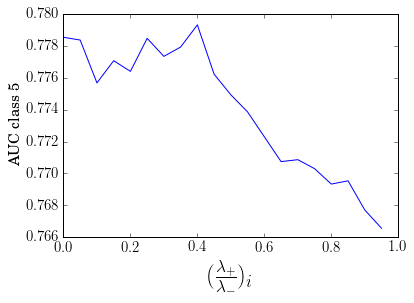

In [560]:
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    params = {'text.usetex' : True,
          'font.size' : 15,
#          'font.family' : 'lmodern',
          'text.latex.unicode': True}
    plt.rcParams.update(params) 
    plt.tick_params(axis='both', which='major')


plt.xlabel(r"$(\frac{\lambda_+}{\lambda_-})_i$", fontsize=25)
plt.ylabel('AUC class 5', fontsize=15)
plt.tick_params(axis='both', which='major')
#plt.title( fontsize=15)
plt.plot(x,y)
plt.savefig("hyper5.eps", bbox_inches = 'tight')
plt.show()

In [506]:
v=res

In [550]:
y

[0.77854204472578348,
 0.77836726718650195,
 0.77567855838763067,
 0.77707282708294467,
 0.77640387614982198,
 0.7784752626682947,
 0.77734550123392099,
 0.77793129970270014,
 0.77931816097314954,
 0.77622640785481745,
 0.77493338895593977,
 0.7738596221778391,
 0.77230090583236244,
 0.77074383773624944,
 0.77086450285253627,
 0.77030213814435977,
 0.76933433900400461,
 0.76953830941043877,
 0.76771160651613468,
 0.76656224024037267]

In [67]:
x=list()
for a in sorted(res):
    x.append(res[a])
b=np.array(x)

In [62]:
b=np.array(x)

In [70]:
x=list(np.max(b[:, :], axis=0))

In [71]:
x

[0.89282985038436669,
 0.89727113464254815,
 0.83299493740397423,
 0.86527959567507984]

In [73]:
a.

NameError: name 'getXY' is not defined

In [79]:
Y1=Y[:,[0,1,2,4,7,9]]

In [89]:
len([0])

2960

In [93]:
i1=np.where(np.all(Y1[:,:]!=999,axis=1))[0]

In [94]:
XAR=X[i1]

In [95]:
XAR

array([[  9.00000000e+00,   4.44444450e-01,   8.00000010e-01, ...,
          2.69529450e+02,   3.38907260e+02,   3.21499990e+00],
       [  6.00000000e+00,   5.00000000e-01,   1.00000000e+00, ...,
          1.49223880e+02,   1.56622860e+02,  -9.68999980e-01],
       [  1.10000000e+01,   4.54545470e-01,   8.33333310e-01, ...,
          3.21070310e+02,   4.88374020e+02,   2.64700010e+00],
       ..., 
       [  2.00000000e+00,   5.00000000e-01,   1.00000000e+00, ...,
          1.20289670e+02,   1.10622240e+02,   2.13908000e+00],
       [  6.00000000e+00,   5.00000000e-01,   1.00000000e+00, ...,
          1.40402280e+02,   1.63656300e+02,  -3.45000000e-01],
       [  9.00000000e+00,   4.44444450e-01,   8.00000010e-01, ...,
          2.24191800e+02,   2.70329830e+02,  -1.34800000e+00]])

In [97]:
YAR=Y1[i1]

In [116]:
np.where(YAR[:,4]==1)

(array([   8,  196,  251,  328,  338,  447,  448,  539,  555,  564,  621,
         643,  705,  726,  752,  871,  895,  962, 1027, 1183, 1224, 1439,
        1492, 2398, 2422, 2531, 2935, 2938]),)

In [105]:
YAR

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ..., 
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int16)

fit 0
adjust 0
Got FPR=20.0 % TPR=87.8 %
updatePredictions 0
fit 1
adjust 1
Got FPR=20.0 % TPR=93.8 %
updatePredictions 1
fit 2
adjust 2
Got FPR=20.0 % TPR=93.7 %
updatePredictions 2
fit 3
adjust 3
Got FPR=20.0 % TPR=89.0 %
updatePredictions 3
fit 4
adjust 4
Got FPR=20.0 % TPR=77.1 %
updatePredictions 4
fit 5
adjust 5
Got FPR=20.0 % TPR=79.5 %
updatePredictions 5
calculating ROC...


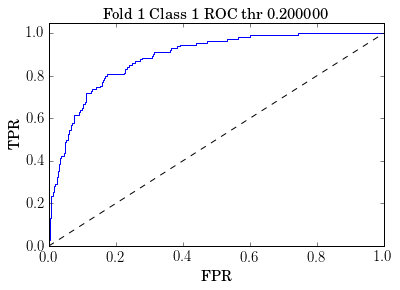

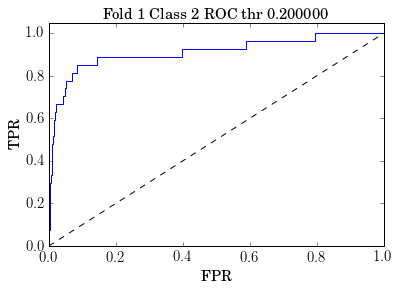

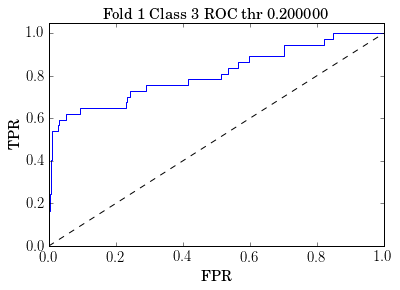

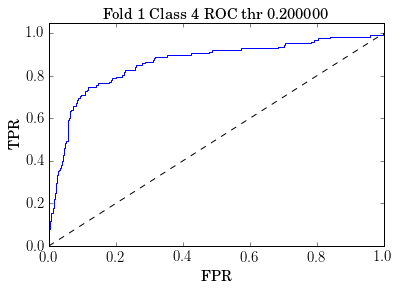

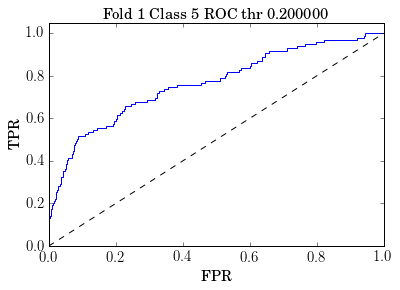

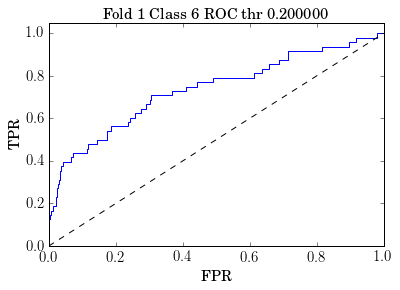

fit 0
adjust 0
Got FPR=20.0 % TPR=87.5 %
updatePredictions 0
fit 1
adjust 1
Got FPR=20.0 % TPR=92.6 %
updatePredictions 1
fit 2
adjust 2
Got FPR=20.0 % TPR=88.7 %
updatePredictions 2
fit 3
adjust 3
Got FPR=20.0 % TPR=88.9 %
updatePredictions 3
fit 4
adjust 4
Got FPR=20.0 % TPR=77.4 %
updatePredictions 4
fit 5
adjust 5
Got FPR=20.0 % TPR=80.0 %
updatePredictions 5
calculating ROC...


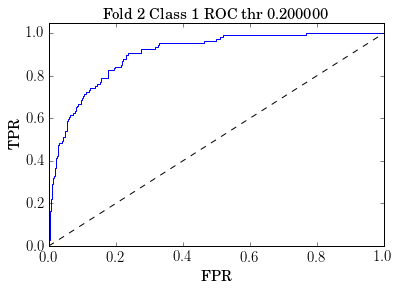

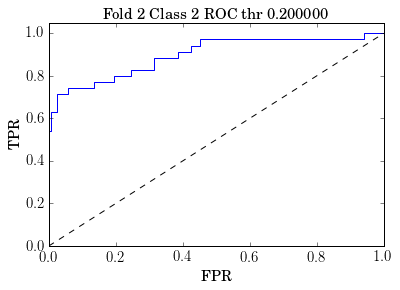

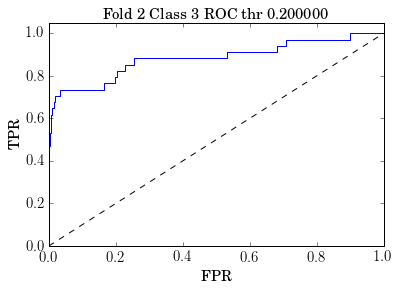

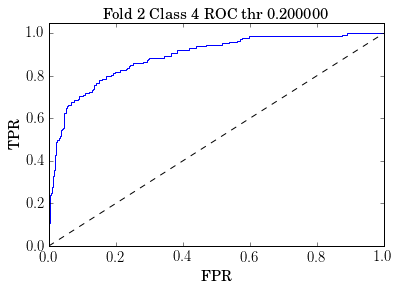

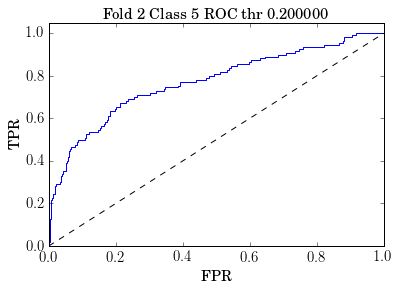

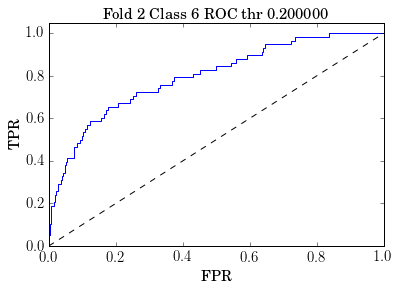

fit 0
adjust 0
Got FPR=20.0 % TPR=89.5 %
updatePredictions 0
fit 1
adjust 1
Got FPR=20.0 % TPR=92.4 %
updatePredictions 1
fit 2
adjust 2
Got FPR=20.0 % TPR=89.2 %
updatePredictions 2
fit 3
adjust 3
Got FPR=20.0 % TPR=88.3 %
updatePredictions 3
fit 4
adjust 4
Got FPR=20.0 % TPR=75.8 %
updatePredictions 4
fit 5
adjust 5
Got FPR=20.0 % TPR=84.7 %
updatePredictions 5
calculating ROC...


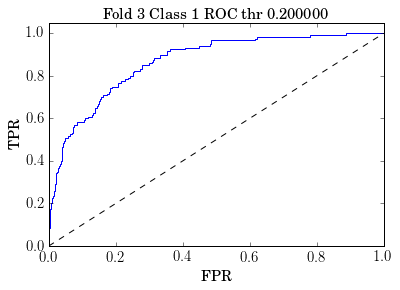

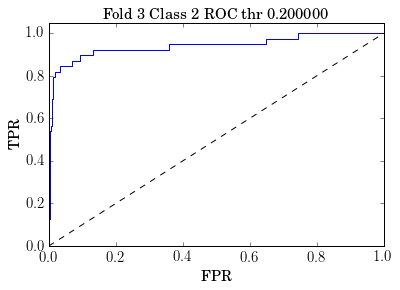

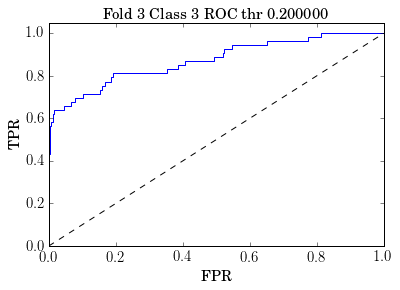

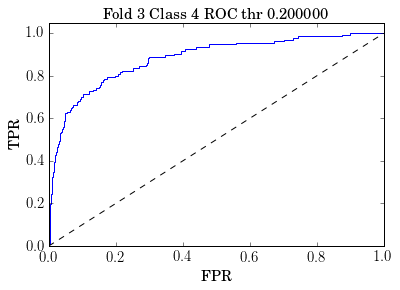

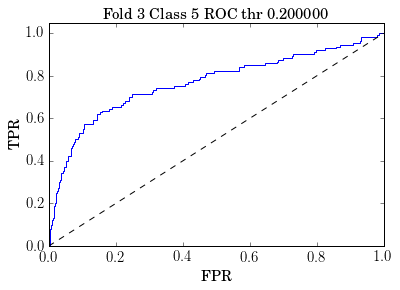

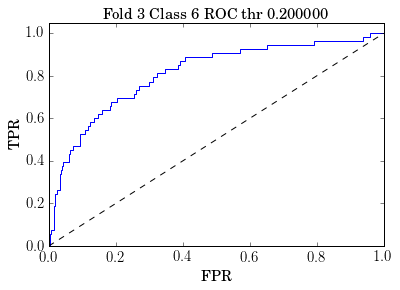

fit 0
adjust 0
Got FPR=20.0 % TPR=87.0 %
updatePredictions 0
fit 1
adjust 1
Got FPR=20.0 % TPR=94.1 %
updatePredictions 1
fit 2
adjust 2
Got FPR=20.0 % TPR=88.7 %
updatePredictions 2
fit 3
adjust 3
Got FPR=20.0 % TPR=87.6 %
updatePredictions 3
fit 4
adjust 4
Got FPR=20.0 % TPR=74.7 %
updatePredictions 4
fit 5
adjust 5
Got FPR=20.0 % TPR=81.6 %
updatePredictions 5
calculating ROC...


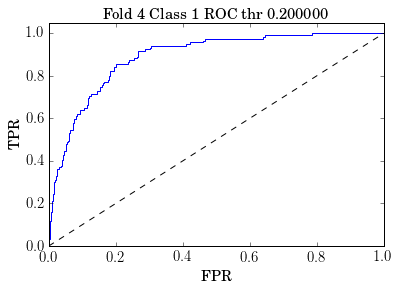

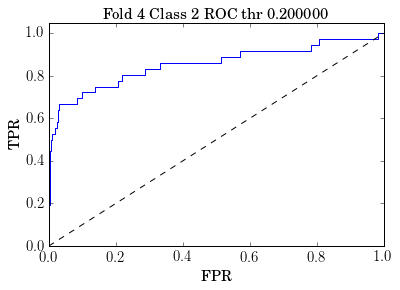

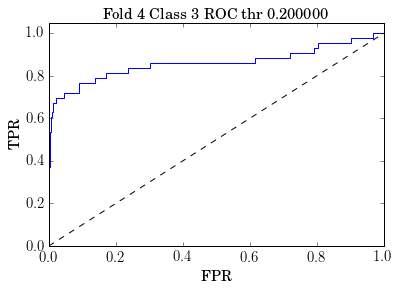

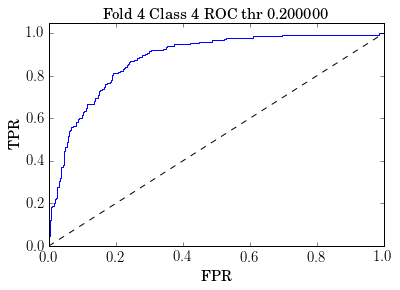

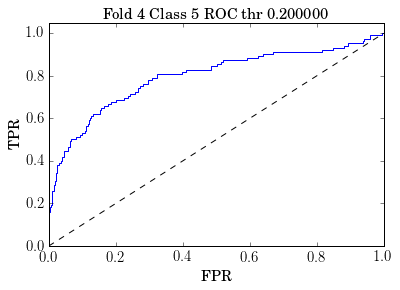

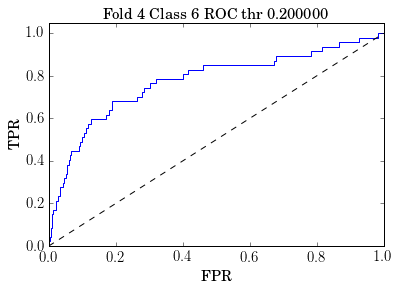

fit 0
adjust 0
Got FPR=20.0 % TPR=88.1 %
updatePredictions 0
fit 1
adjust 1
Got FPR=20.0 % TPR=92.0 %
updatePredictions 1
fit 2
adjust 2
Got FPR=20.0 % TPR=91.0 %
updatePredictions 2
fit 3
adjust 3
Got FPR=20.0 % TPR=86.9 %
updatePredictions 3
fit 4
adjust 4
Got FPR=20.0 % TPR=74.2 %
updatePredictions 4
fit 5
adjust 5
Got FPR=20.0 % TPR=80.6 %
updatePredictions 5
calculating ROC...


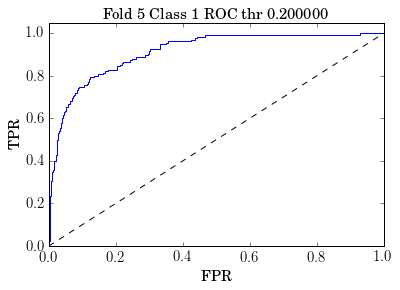

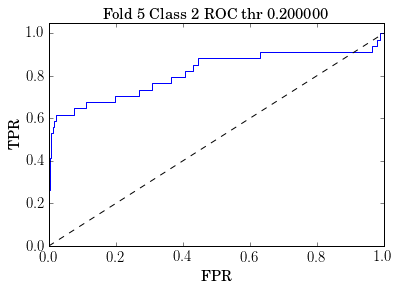

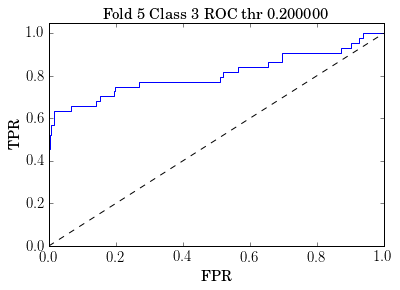

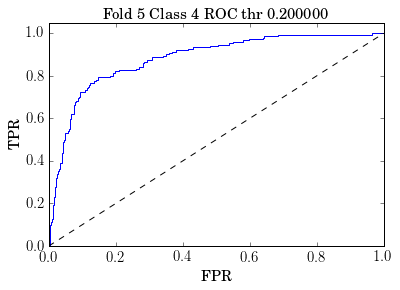

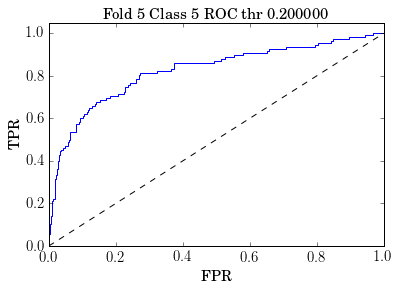

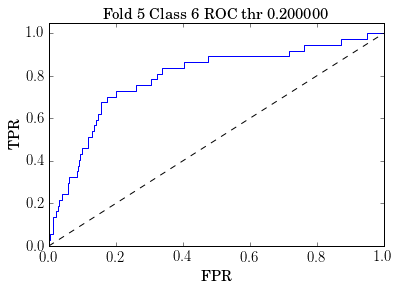

Class 1 AUC 0.89 +- 0.02 thres 0.200000
Class 2 AUC 0.88 +- 0.04 thres 0.200000
Class 3 AUC 0.85 +- 0.03 thres 0.200000
Class 4 AUC 0.88 +- 0.01 thres 0.200000
Class 5 AUC 0.79 +- 0.02 thres 0.200000
Class 6 AUC 0.78 +- 0.03 thres 0.200000


In [149]:
res=AUCAll(0.2)

In [147]:
res*5

array([ 0.89289219,  0.91312344,  0.81678308,  0.85842127])